# ***Libraries and Modules Import***

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from tabulate import tabulate

# ***Data Preprocessing: Stopwords Removal and Text Normalization***

In [2]:
# Text preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# ***Function: Calculate Within-Cluster Sum of Squares (WCSS)***

In [3]:
def calculate_wcss(X):
    wcss = []
    for i in range(1, 21):
        kmeans = KMeans(n_clusters=i, init='random', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    return wcss

# ***Function: Find Elbow Point from Within-Cluster Sum of Squares (WCSS)***

In [4]:
def find_elbow_point(wcss):
    differences = np.diff(wcss)
    second_differences = np.diff(differences)
    elbow_index = np.where(second_differences == max(second_differences))[0][0]
    elbow_point = elbow_index + 2
    return elbow_point

In [5]:
def visualize_elbow(wcss):
    plt.plot(range(1, 21), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

# ***Function: Cluster Data and Visualize Results***

In [6]:
def cluster_and_visualize(X, num_clusters, df, filename_prefix):
    kmeans = KMeans(n_clusters=num_clusters, init='random', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(X)

    df['Cluster'] = cluster_labels

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())

    # Generate clusters visualization
    for i in range(num_clusters):
        plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}')

        # Calculate cluster center
        cluster_center = np.mean(X_pca[cluster_labels == i], axis=0)

        # Calculate cluster radius
        cluster_radius = np.max(np.linalg.norm(X_pca[cluster_labels == i] - cluster_center, axis=1))

        # Plot circle around cluster
        circle = plt.Circle(cluster_center, cluster_radius, color='blue', fill=False)
        plt.gca().add_patch(circle)

    plt.title('Clusters of Career Titles with Circles')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

    # Generate and display word clouds for each cluster
    for i in range(num_clusters):
        cluster_data = df[df['Cluster'] == i]
        cluster_text = ' '.join(cluster_data['Position'])

        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

        # Display the word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Cluster {i}')
        plt.axis('off')
        plt.show()

    # Save data to Excel
    for i in range(num_clusters):
        cluster_data = df[df['Cluster'] == i]
        cluster_data.to_excel(f'{filename_prefix}_cluster_{i}_data.xlsx', index=False)

    return df


In [7]:
def extract_top_keywords(vectorizer, X, filename_prefix):
    feature_names = vectorizer.get_feature_names_out()
    average_tfidf_scores = X.mean(axis=0).tolist()[0]
    term_scores = list(zip(feature_names, average_tfidf_scores))
    term_scores_sorted = sorted(term_scores, key=lambda x: x[1], reverse=True)
    top_keywords = term_scores_sorted[:20]

    plt.figure(figsize=(10, 6))
    keywords, scores = zip(*top_keywords)
    plt.barh(range(len(keywords)), scores, align='center')
    plt.yticks(range(len(keywords)), keywords)
    plt.xlabel('Average TF-IDF Score')
    plt.ylabel('Keywords')
    plt.title(f'Top Keywords Extracted from {filename_prefix.capitalize()} Career Titles')
    plt.gca().invert_yaxis()
    plt.savefig(f'{filename_prefix}_top_keywords_plot.png')
    plt.show()

# ***Function: Extract Top Keywords and Plot Frequencies***

In [8]:
def analyze_careers(df, filename_prefix):
    cleaned_career_titles = [preprocess_text(title) for title in df['Position'].tolist()]

    vectorizer = TfidfVectorizer(min_df=5)
    X = vectorizer.fit_transform(cleaned_career_titles)

    wcss = calculate_wcss(X)
    visualize_elbow(wcss)
    elbow_point = find_elbow_point(wcss)
    num_clusters = elbow_point

    df = cluster_and_visualize(X, num_clusters, df, filename_prefix)
    extract_top_keywords(vectorizer, X, filename_prefix)

    for i in range(num_clusters):
        print(f"Cluster {i} data:")
        cluster_data = df[df['Cluster'] == i]
        print(tabulate(cluster_data, headers='keys', tablefmt='psql'))
        print()

# ***Analysis of EIM Past Career Positions***

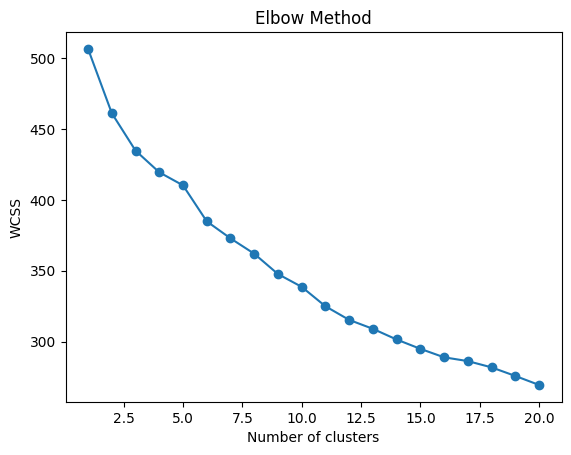

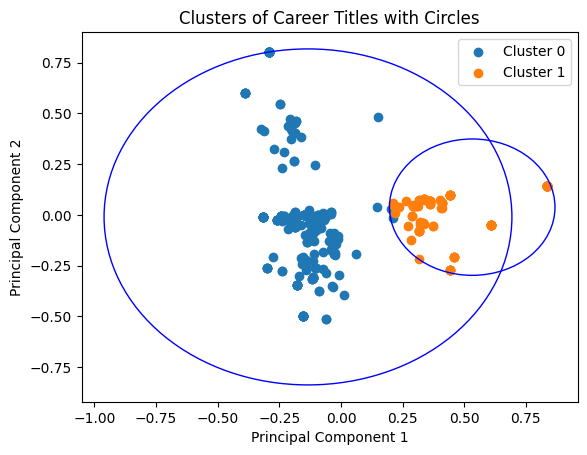

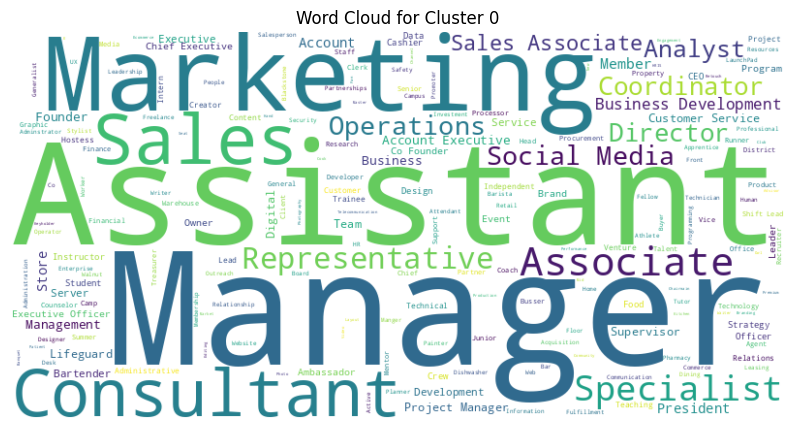

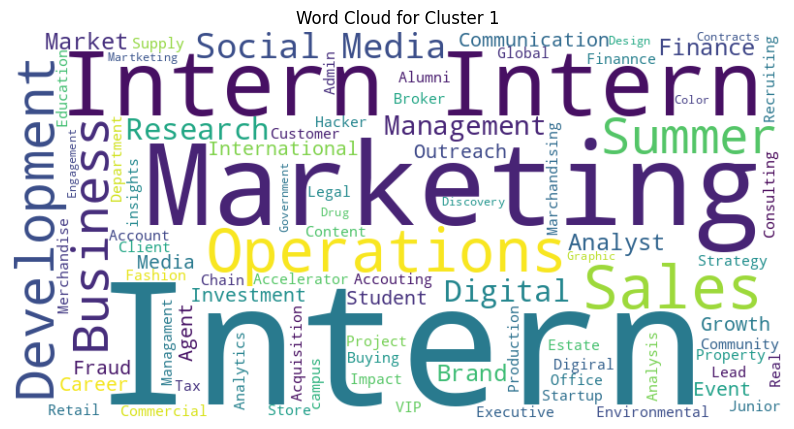

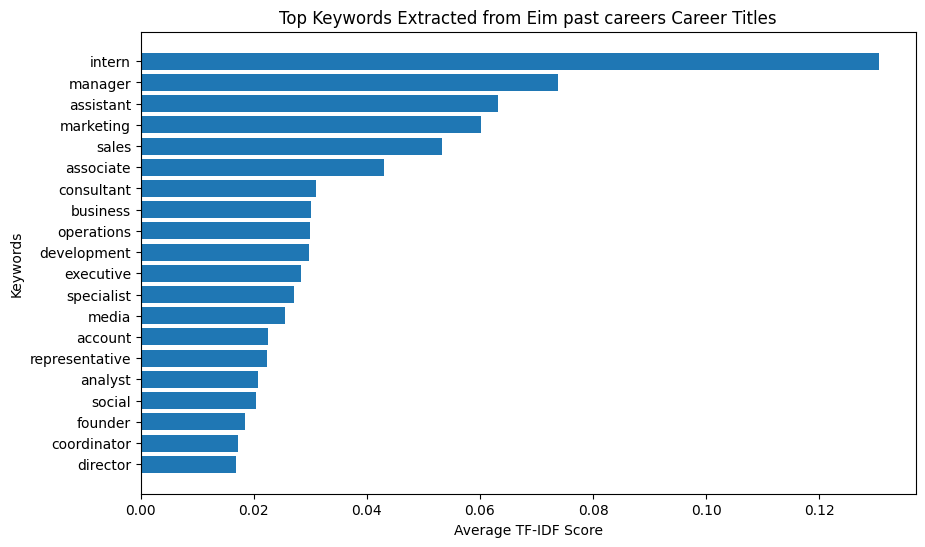

Cluster 0 data:
+-----+----------------------------------------------------------------------+-----------+
|     | Position                                                             |   Cluster |
|-----+----------------------------------------------------------------------+-----------|
|   0 | Analyst                                                              |         0 |
|   2 | Leasing Agent                                                        |         0 |
|   4 | Salesperson                                                          |         0 |
|   5 | Shift Lead                                                           |         0 |
|   6 | Retail Sales Specialist                                              |         0 |
|   7 | Event Production Assistant & Warehouse Hand                          |         0 |
|   9 | Lifeguard                                                            |         0 |
|  10 | Founder & CEO                                                     

In [9]:
past_df = pd.read_csv("/kaggle/input/eim-career/EIM Past Careers.csv")
analyze_careers(past_df, 'EIM Past Careers')

# ***Analysis of EIM Current Career Positions***

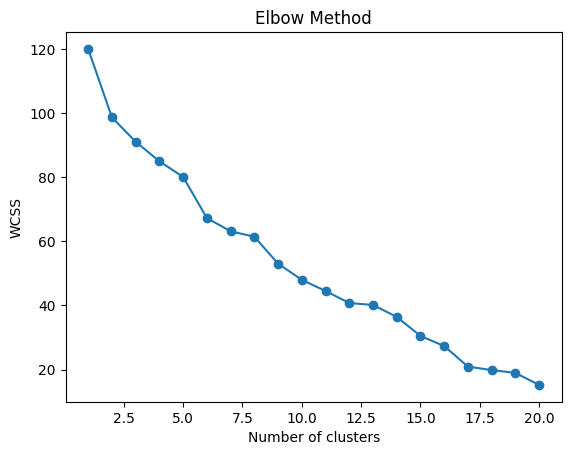

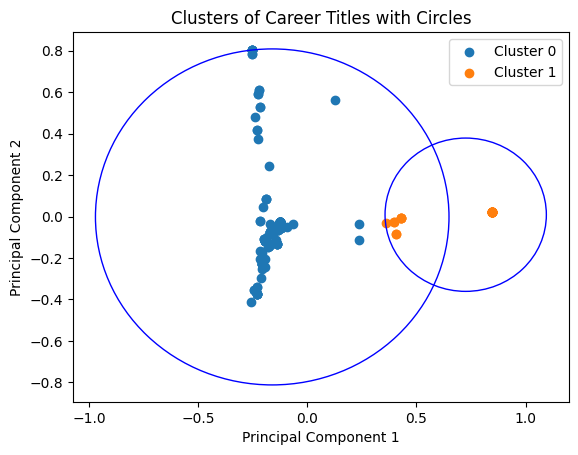

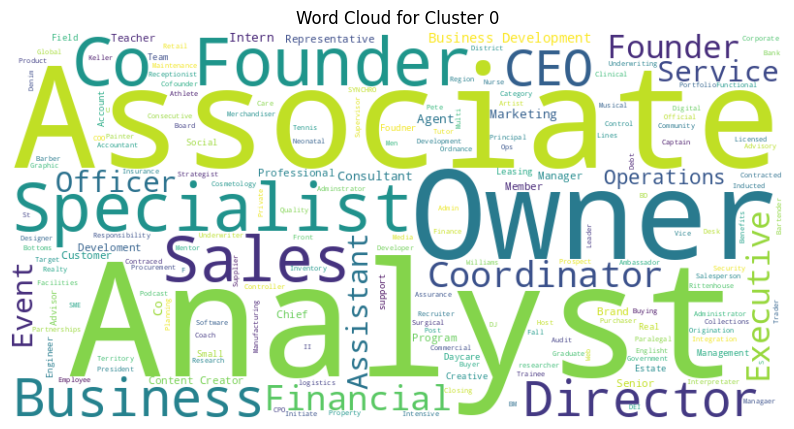

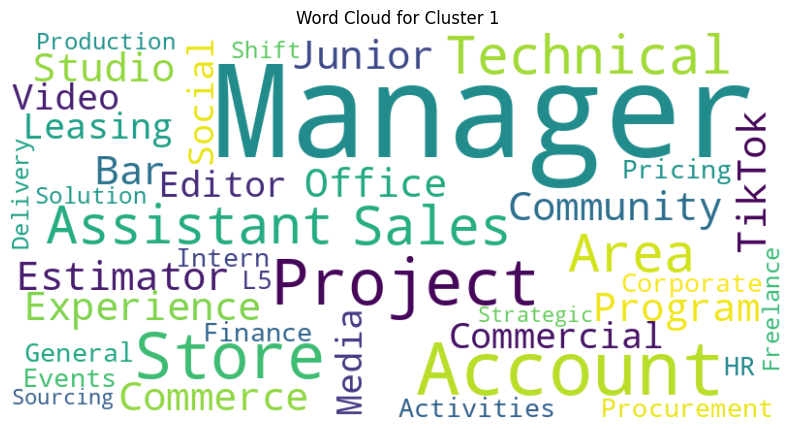

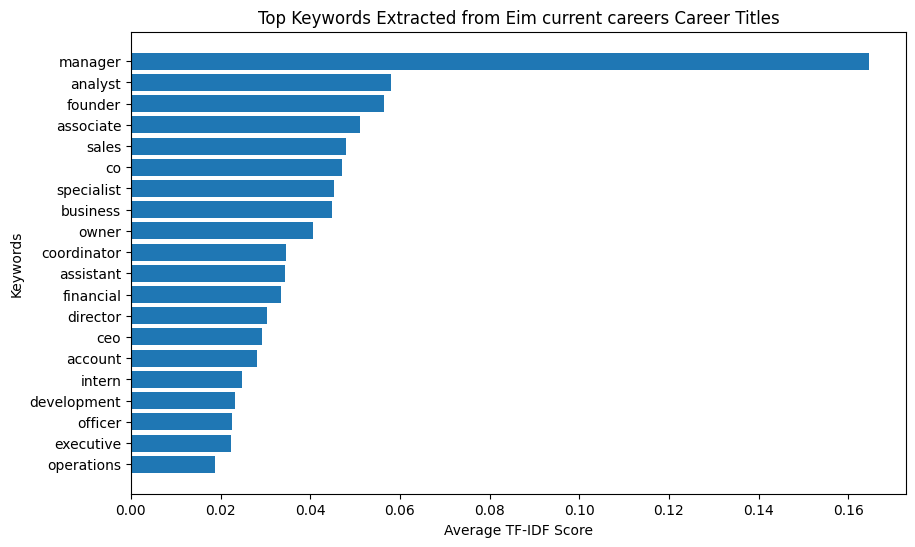

Cluster 0 data:
+-----+---------------------------------------------------------+-----------+
|     | Position                                                |   Cluster |
|-----+---------------------------------------------------------+-----------|
|   0 | Associate Director                                      |         0 |
|   1 | Rittenhouse Realty Advisors                             |         0 |
|   3 | Cofounder and CEO                                       |         0 |
|   4 | Global Graduate Program - Associate Origination Analyst |         0 |
|   6 | Event Coordinator                                       |         0 |
|   7 | Sales Administrator                                     |         0 |
|   9 | Business Development                                    |         0 |
|  10 | Community & Business Development                        |         0 |
|  11 | Field Consultant                                        |         0 |
|  12 | Paralegal                               

In [10]:
current_df = pd.read_csv("/kaggle/input/eim-career/EIM Current Careers.csv")
analyze_careers(current_df, 'EIM Current Careers')

# ***Analysis of IME Past Career Positions***

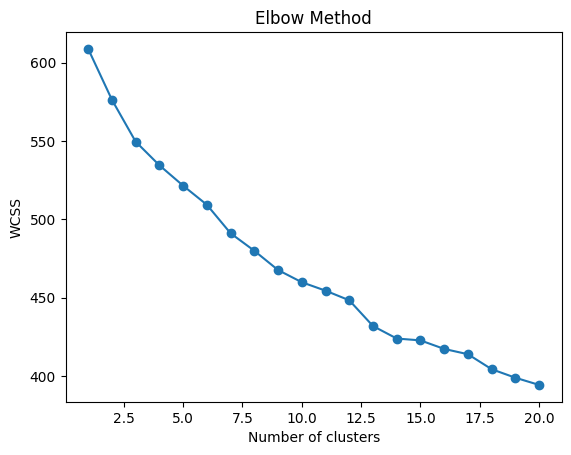

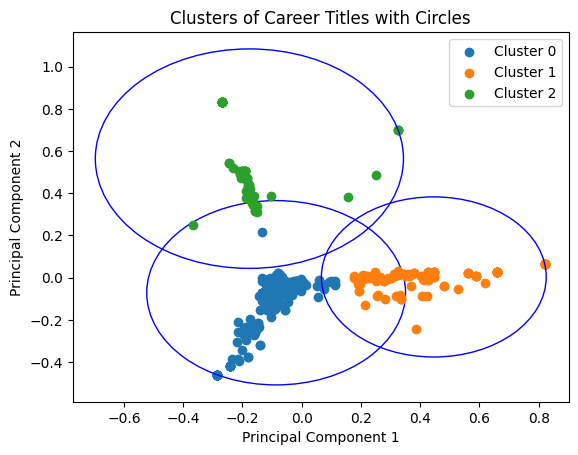

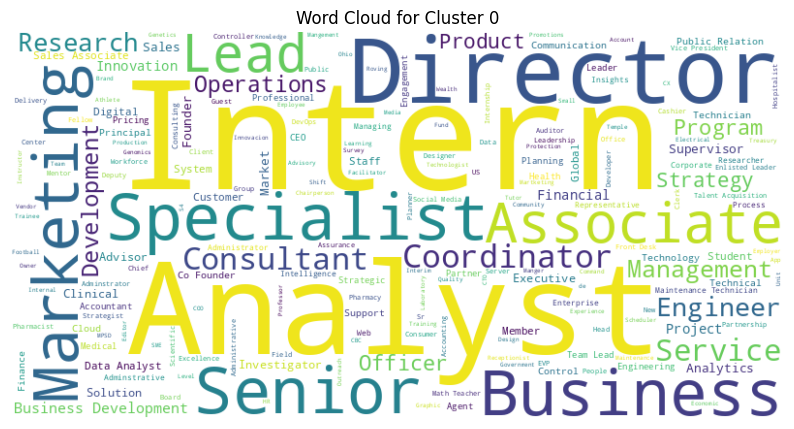

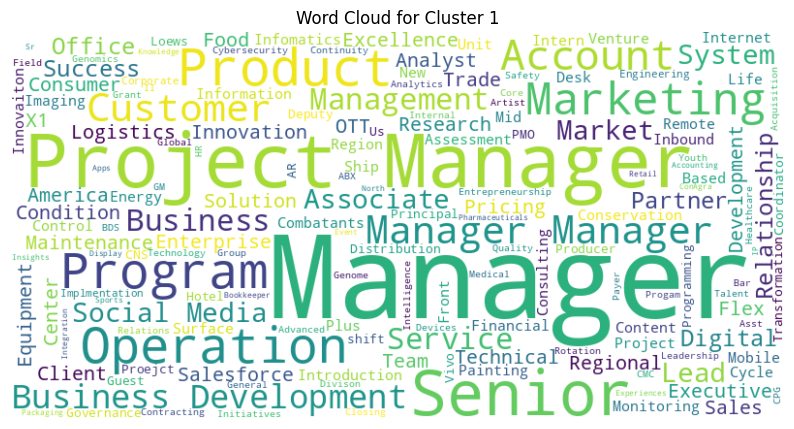

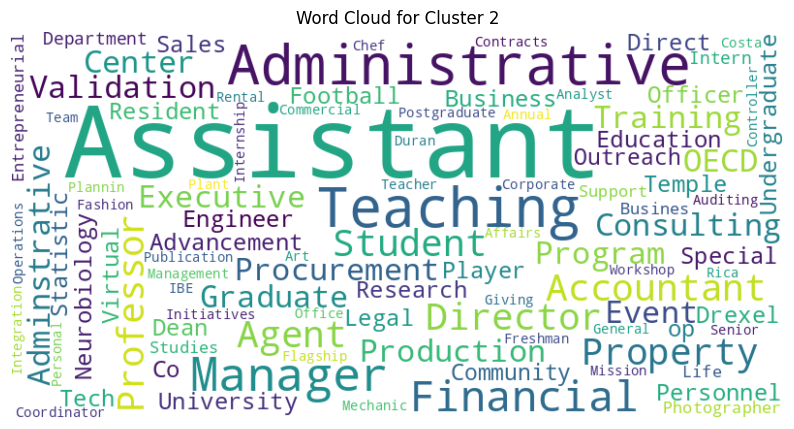

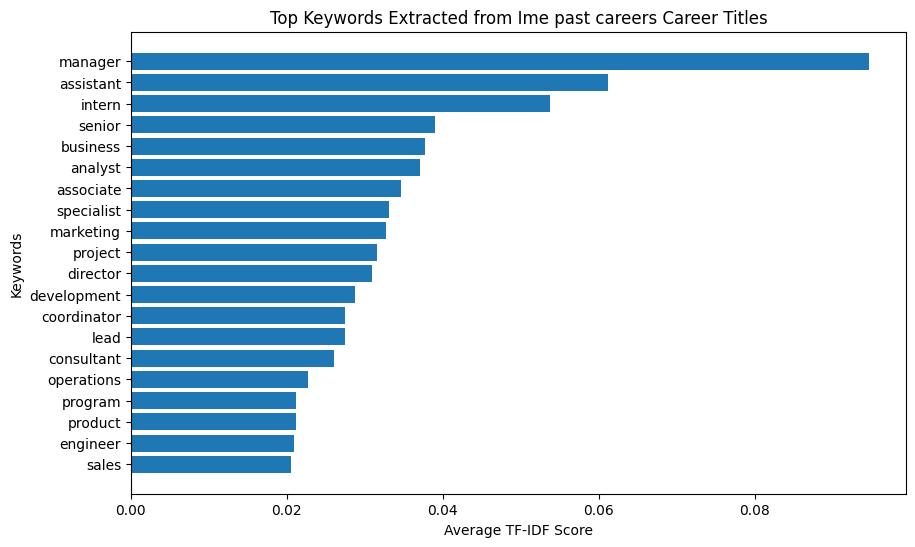

Cluster 0 data:
+-----+-------------------------------------------------------------------------------------------------+-----------+
|     | Position                                                                                        |   Cluster |
|-----+-------------------------------------------------------------------------------------------------+-----------|
|   0 | Co-Founder                                                                                      |         0 |
|   1 | Credit Risk Management                                                                          |         0 |
|   2 | International Finance Internship                                                                |         0 |
|   3 | Learning and Development-Brain Injury Specialist                                                |         0 |
|   4 | Learning Facilitator                                                                            |         0 |
|   7 | Executive Intern                

In [11]:
past_df = pd.read_csv("/kaggle/input/ime-career/IME Past Careers.csv")
analyze_careers(past_df, 'IME Past Careers')

# ***Analysis of IME Current Career Positions***

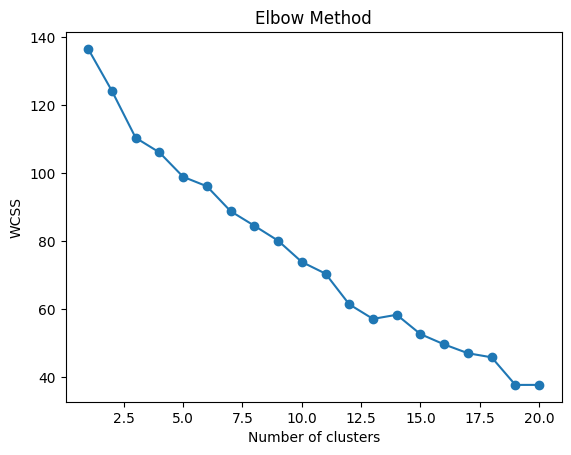

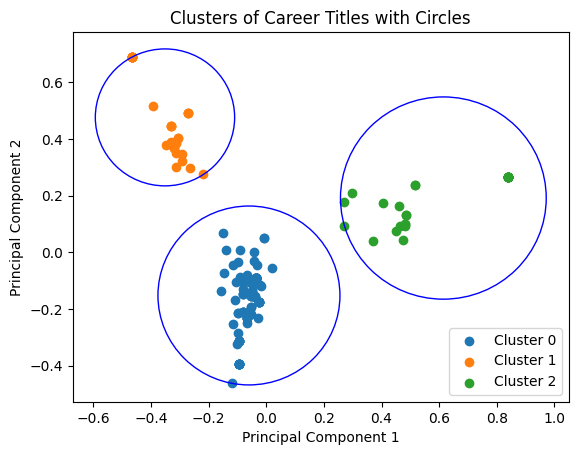

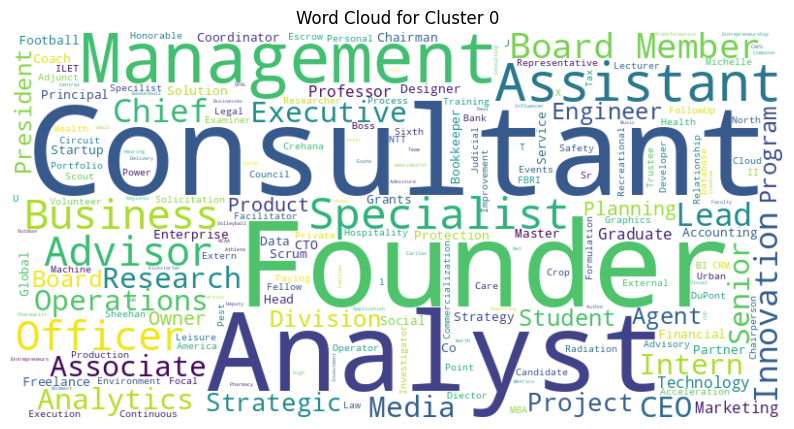

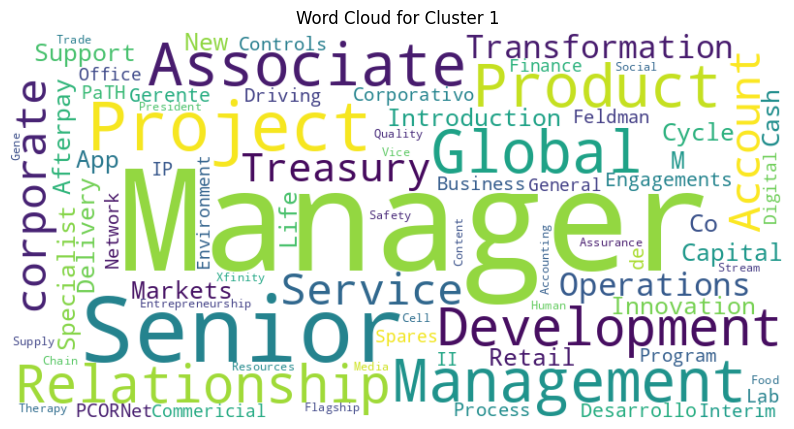

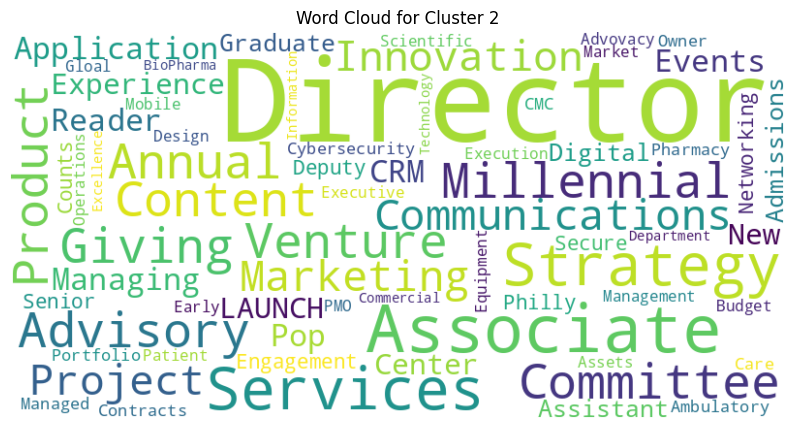

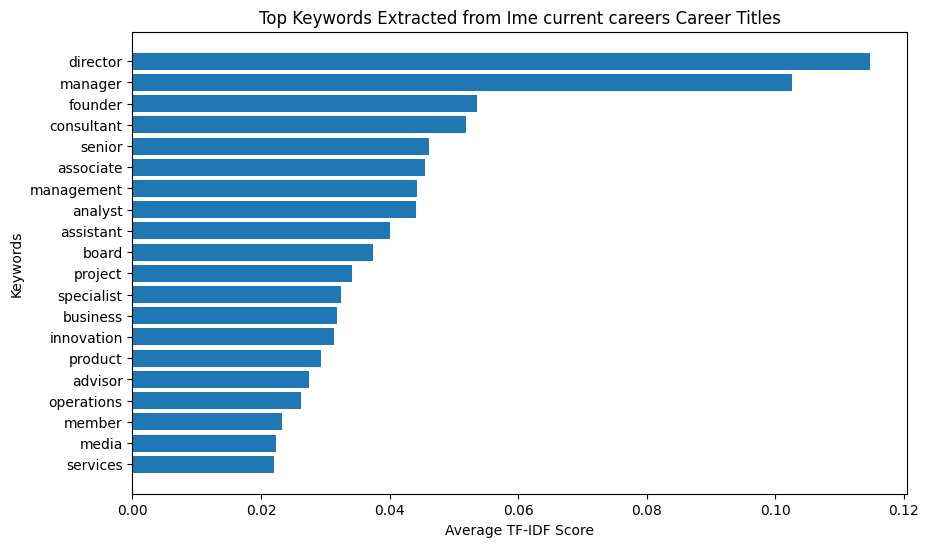

Cluster 0 data:
+-----+---------------------------------------------------------------------------------------------+-----------+
|     | Position                                                                                    |   Cluster |
|-----+---------------------------------------------------------------------------------------------+-----------|
|   0 | Strategic Management Intern                                                                 |         0 |
|   1 | Project Management Assistant                                                                |         0 |
|   2 | Chief Executive Officer and Lead Consultant                                                 |         0 |
|   3 | Associate Training Specialist - Environment Health and Radiation Safety                     |         0 |
|   6 | Research Assistant                                                                          |         0 |
|   7 | Legal Intern                                                    

In [12]:
past_df = pd.read_csv("/kaggle/input/ime-career/IME Current Careers.csv")
analyze_careers(past_df, 'IME Current Careers')